## QA prompt engineering and LLM parameters to match a representative sample of citizens

In [2]:
import os
import sys
sys.path.append("../../../")

import pandas as pd

from src.llms_helpers.openai_api import query_open_ai
from src.eval_utils.experimenter import ExperimentRunner, Data, ModelConfig, SurveyConfig, EvalConfig
from src.data_helpers.mapper_wuw_meaning import profile_questions, energy_calculations, factors_to_be_considered_keys_flat, factors_to_be_considered_keys

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

### 1. Generate Prompts

In [3]:
df_sample = pd.read_csv("../../../data/ariadne/heating_buildings/df_cata_sample_50_processed_relevant_factors_citizen_type.csv", encoding='ISO-8859-1')
df_questions = pd.read_csv("../../../data/ariadne/heating_buildings/questions_selected_survey_mapper_encoded.csv", sep=';', encoding='utf-8', on_bad_lines='skip')

In [4]:
df_questions.head(2)

,question_id,Question,option_type,exclude_values,mapping_dict
0,ges,Geschlecht,categorical,NaN,"{'1':'männlich', '2':'weiblich'}"
1,city_category,City size,ordinal,NaN,"{'1':'weniger als 20.000 Einwohner','2':'zwisc..."


### 2. Run and evaluate experiment

In [5]:
standard_entries = ['key','citizen_type'] + profile_questions + energy_calculations + factors_to_be_considered_keys_flat
df_answers = df_sample[(df_sample['citizen_type']!='defier') & (df_sample['key'].isin([806927261, 661238641, 817443461]))][standard_entries].head(10)

In [6]:
df_answers

,key,citizen_type,bundesland_name,ges,altq,city_category,so5,so1,so2,ist6,...,so3_3,so3_6,so3_7,so3_8,so3_9,so3_10,so3_11,so3_12,so7,so8
6,661238641,free rider,Freistaat Bayern,1,56,1,12,4,9,7,...,0,0,0,0,0,0,0,0,7,1
8,817443461,complier,Freistaat Sachsen,2,52,1,12,6,13,6,...,0,0,0,0,0,0,0,0,3,2
10,806927261,never taker,Rheinland-Pfalz,1,62,1,12,4,4,7,...,0,0,0,0,0,0,0,0,8,1


In [7]:
# parameters prompt engineering
num_questions=12 
rand_question_order=factors_to_be_considered_keys
survey_context="custom_subject"
final_question="custom_subject"
final_question_prompt="TA"
rand_order_options=False
prompts_directory="../../../data/ariadne/heating_buildings/experiment_1/prompts"

# parameters run estimations
n_trials = 3
model = "gpt-4-1106-preview" # "gpt-3.5-turbo"  #"gpt-4"#"babbage-002"

# parameters for evaluation
mapper = {'A': 1, 'B': 2}
final_columns = ['ea801', 'ea802', 'ea803', 'ea804', 'ea805', 'ea806', 'ea807', 'ea808', 'ea809', 'ea810', 'ea811', 
               'ea812', 'ea813', 'ea814', 'ea815']

### 2. Run a recurrent experiment and analyse the results

**Observations**
* Temperature 0.5 differenciates between the different profiles way of thinking.
* Temperature 0.7 differenciates between the different profiles way of thinking and includes into the thoughts the numbers given in a more comprehensive way.
* The limitation of 400 tokens in the reflection breaks the sentences in the middle and therefore, the following request of the final options do not work well.
* Increase to 500 tokens limit is also not enough.
* Add a constrain in the prompt to limit thoughts to no more than 300 words fixed it.
* The estimations with temperature 0.7 are slightly better when there is a response in the right format.
* The cases where the response do not match the expected format is because the reasoning was not completed. Decreasing the size of reasoning to 250 words decreases the quality. 
* The increase to 700 tokens maximum of reasoning, adding the prompt instruction to be below 300 words and the additional instruction after the reasoning with the example of how options should be provided avoid the errors happening. However, the large space for reasoning seem to shift decisions towards option B.
* Decrease the size of reasoning again to 250 keeping the more detailed guidance and the threshold to 700 tokens just in case. However, the quality of the decisions decrease making irrational decisions such as choosing simple renovation at lower prices and extensive renovation when prices are higher.
* When increasing the size of the reasoning, there is a tendency to choose more option B, thus, simplify prompt closer to the original version. Still, that a different way of thinking is applied that moves tendency towards B. No case where all options are A is observed anymore. Most likely, the reasoning is limiting emotional decision-making.
* Removing the statement added of having 1500 euros available, I analized the reasoning of the individual that in real life choose simple renovation. One of the questions presented in the prompt highlighted the tendency to short term profit and in the reasoning it highlights that. However, the final decision is that one which is "purely rational". Thus, I am avoiding emotional-driven decision making.
* Giving instructions to the AI directly to mimic only the personality reflected in the previous prompt seems to work better despite of still being slightly more rational than the actual humans. However, the reproducibility of the responses is much higher. 
    * With GPT-3.5 I manage to get all options A for those that only A but, on the other hand, it keeps on making the mistake of choosing A first and then B in other cases as well as not managing to provide a structured shape of the responses.
    * With GPT-4 I do not manage to avoid getting option B in at least the 4 first decisions despite of reproducibility increases and it clearly distinguishes that the person thinks in a certain way.
* The direct target of AI to mimic the human behind the answers previously given works much better at 0.5, 0.6 and 0.7 in terms of reproducibility of results across 3 iterations and to distinguish the human that only wants to go for simple renovation at any price vs the other two. However, it does not perform that well with reproducing the results for the subject that always chooses comprehensive renovation. My perception is that the algorithm tries to reproduce the responses from an objective and quantitative perspective and does not caputre the emotional personal interests. It makes the decisions based on the financial aspects. The prompt given also emphasizes those aspects and therefore the following tests should be run:
    * Compare results when shaping the prompt more balanced between financial interest and personal beliefs --> decide prompt and temperature
    * Compare results when running the experiment with chosen factors based on literature and crucial requirements for shaping the profile of the people
    * Compare results when using different number of questions

In [8]:
factors_log_reg_analysis = ['is_high_wealth','long_term_prof_year_low','building_type_Reihen-/Doppelhaus',
                            'altru_future','ownership_2','humans_vs_natur_5','humans_vs_natur_2','years_in_flat_future',
                            'years_in_flat','n_housholds']
factors_literature = ['a1','a4','bel2_1','altru1_2','so7','pk35','pk1_5','pk1_1','pk2_2','pk2_3']

'gpt-4-1106-preview'

In [13]:
temperature = [0.6]#[0.5, 0.7]
top_p = 1.0
max_tokens = 100
n_iter = 3
custom_question_ids = []

data = Data(df_questions, df_answers, custom_question_ids)
model_config = ModelConfig(model, n_trials)
survey_config = SurveyConfig(n_iter, num_questions, rand_question_order, survey_context, final_question, final_question_prompt, rand_order_options)
eval_config = EvalConfig(mapper, final_columns)

additional_sentence = """Interviewer: Bitte entscheiden sich nun für die verschiedenen Optionen. Halten Sie Ihre Antworten in einer nummerierten Liste organisiert: '1. (Option Buchstabe) 2. (Option Buchstabe) 3. (Option Buchstabe) usw.\nIch:"""
for temp in temperature:
    output_file = f"../../../data/ariadne/heating_buildings/experiment_1/recurrent_{model}-t_{temp}_qa.csv"
    exp_run = ExperimentRunner(data=data, model_config=model_config, survey_config=survey_config, eval_config=eval_config)
    exp_run.generate_prompts()
    exp_run.store_prompts(directory=prompts_directory)
    exp_run.run_recurrent_experiment(output_file, temp, top_p, max_tokens, additional_sentence)

Skipping qustion as subject did not give a valid answer.
Interviewer: Sie sind Eigentümer eines Hauses und haben die Kontrolle über Entscheidungen bezüglich der Heizung und Sie besitzen eine Zentralheizung und Ihre Immobilie wurde 1984 bis 1994 gebaut. Bitte erzählen Sie uns ein wenig über sich selbst.

Ich: Ich bin ein 56 Jahre alter Mann und ich wohne in einer Stadt mit weniger als 20.000 Einwohnern in Freistaat Bayern. Zusätzlich, mein Einkommensniveau beträgt 5.700 Euro und mehr pro Monat und mein höchster Bildungsabschluss ist Berufsakademie, Fachakademie.
Interviewer: Wie viele Personen, also Erwachsene und Kinder (inkl. Sie selbst), wohnen derzeit in Ihrem Haushalt?
Ich: NUMFELD 2

Interviewer: In welcher Art von Gebäude befindet sich die Wohnung?
Bitte wählen Sie nur eine der folgenden Optionen mit dem dazugehörigen Buchstaben aus.
(a) freistehendes Ein-/ Zweifamilienhaus (b) Reihen-/Doppelhaus (c) in einem Mehrfamilienhaus (bis zu sieben Stockwerke) (d) in einem Hochhaus (acht

### 3. Analysis of results

#### 3.3.1. Results temperature 0.6 iteration 1

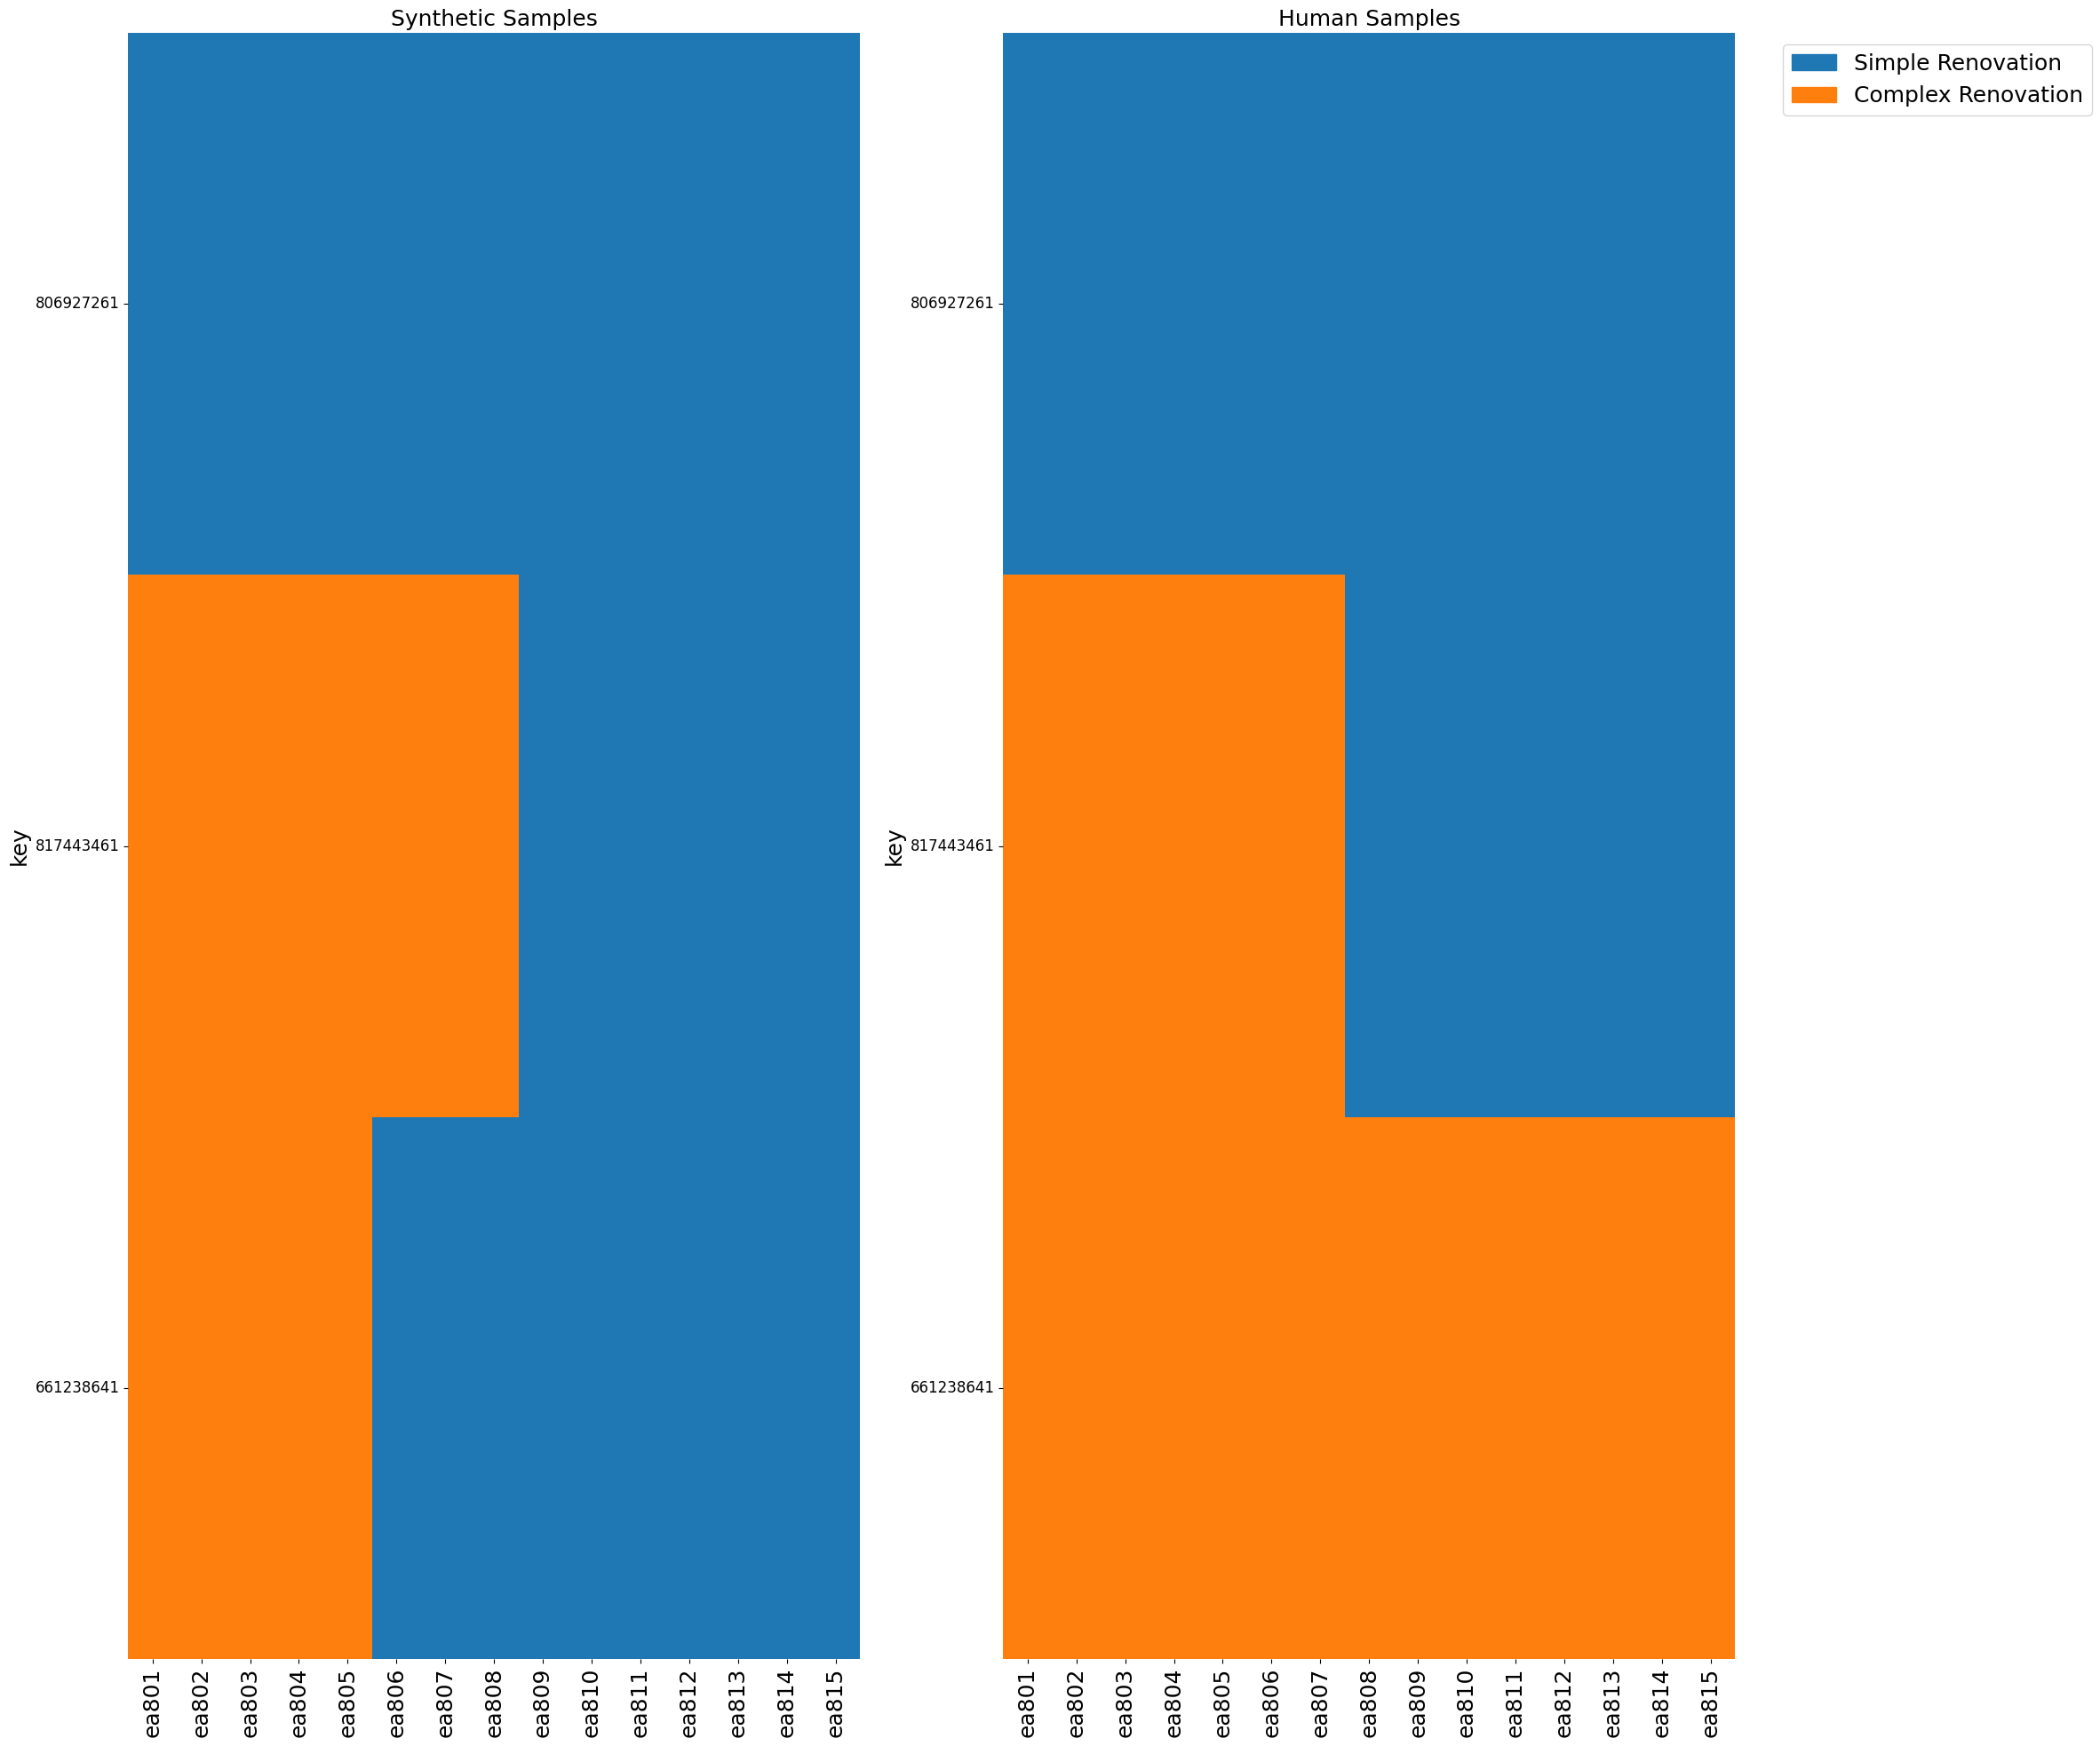

In [14]:
df_human_sample = df_sample[(df_sample['citizen_type']!='defier') & (df_sample['key'].isin([806927261, 661238641, 817443461]))].head(10)[['key']+final_columns]
output_file = '../../../data/ariadne/heating_buildings/experiment_1/20240102_1512/recurrent_gpt-4-1106-preview-t_0.6_qa.csv'
df_synthetic_samples = pd.read_csv(output_file)
df_synthetic_samples = df_synthetic_samples[(df_synthetic_samples['iter']==0)&(df_synthetic_samples['temperature']==0.6)]
exp_run.compare_results(df_human_sample, df_synthetic_samples)

#### 3.3.1. Results temperature 0.6 iteration 2

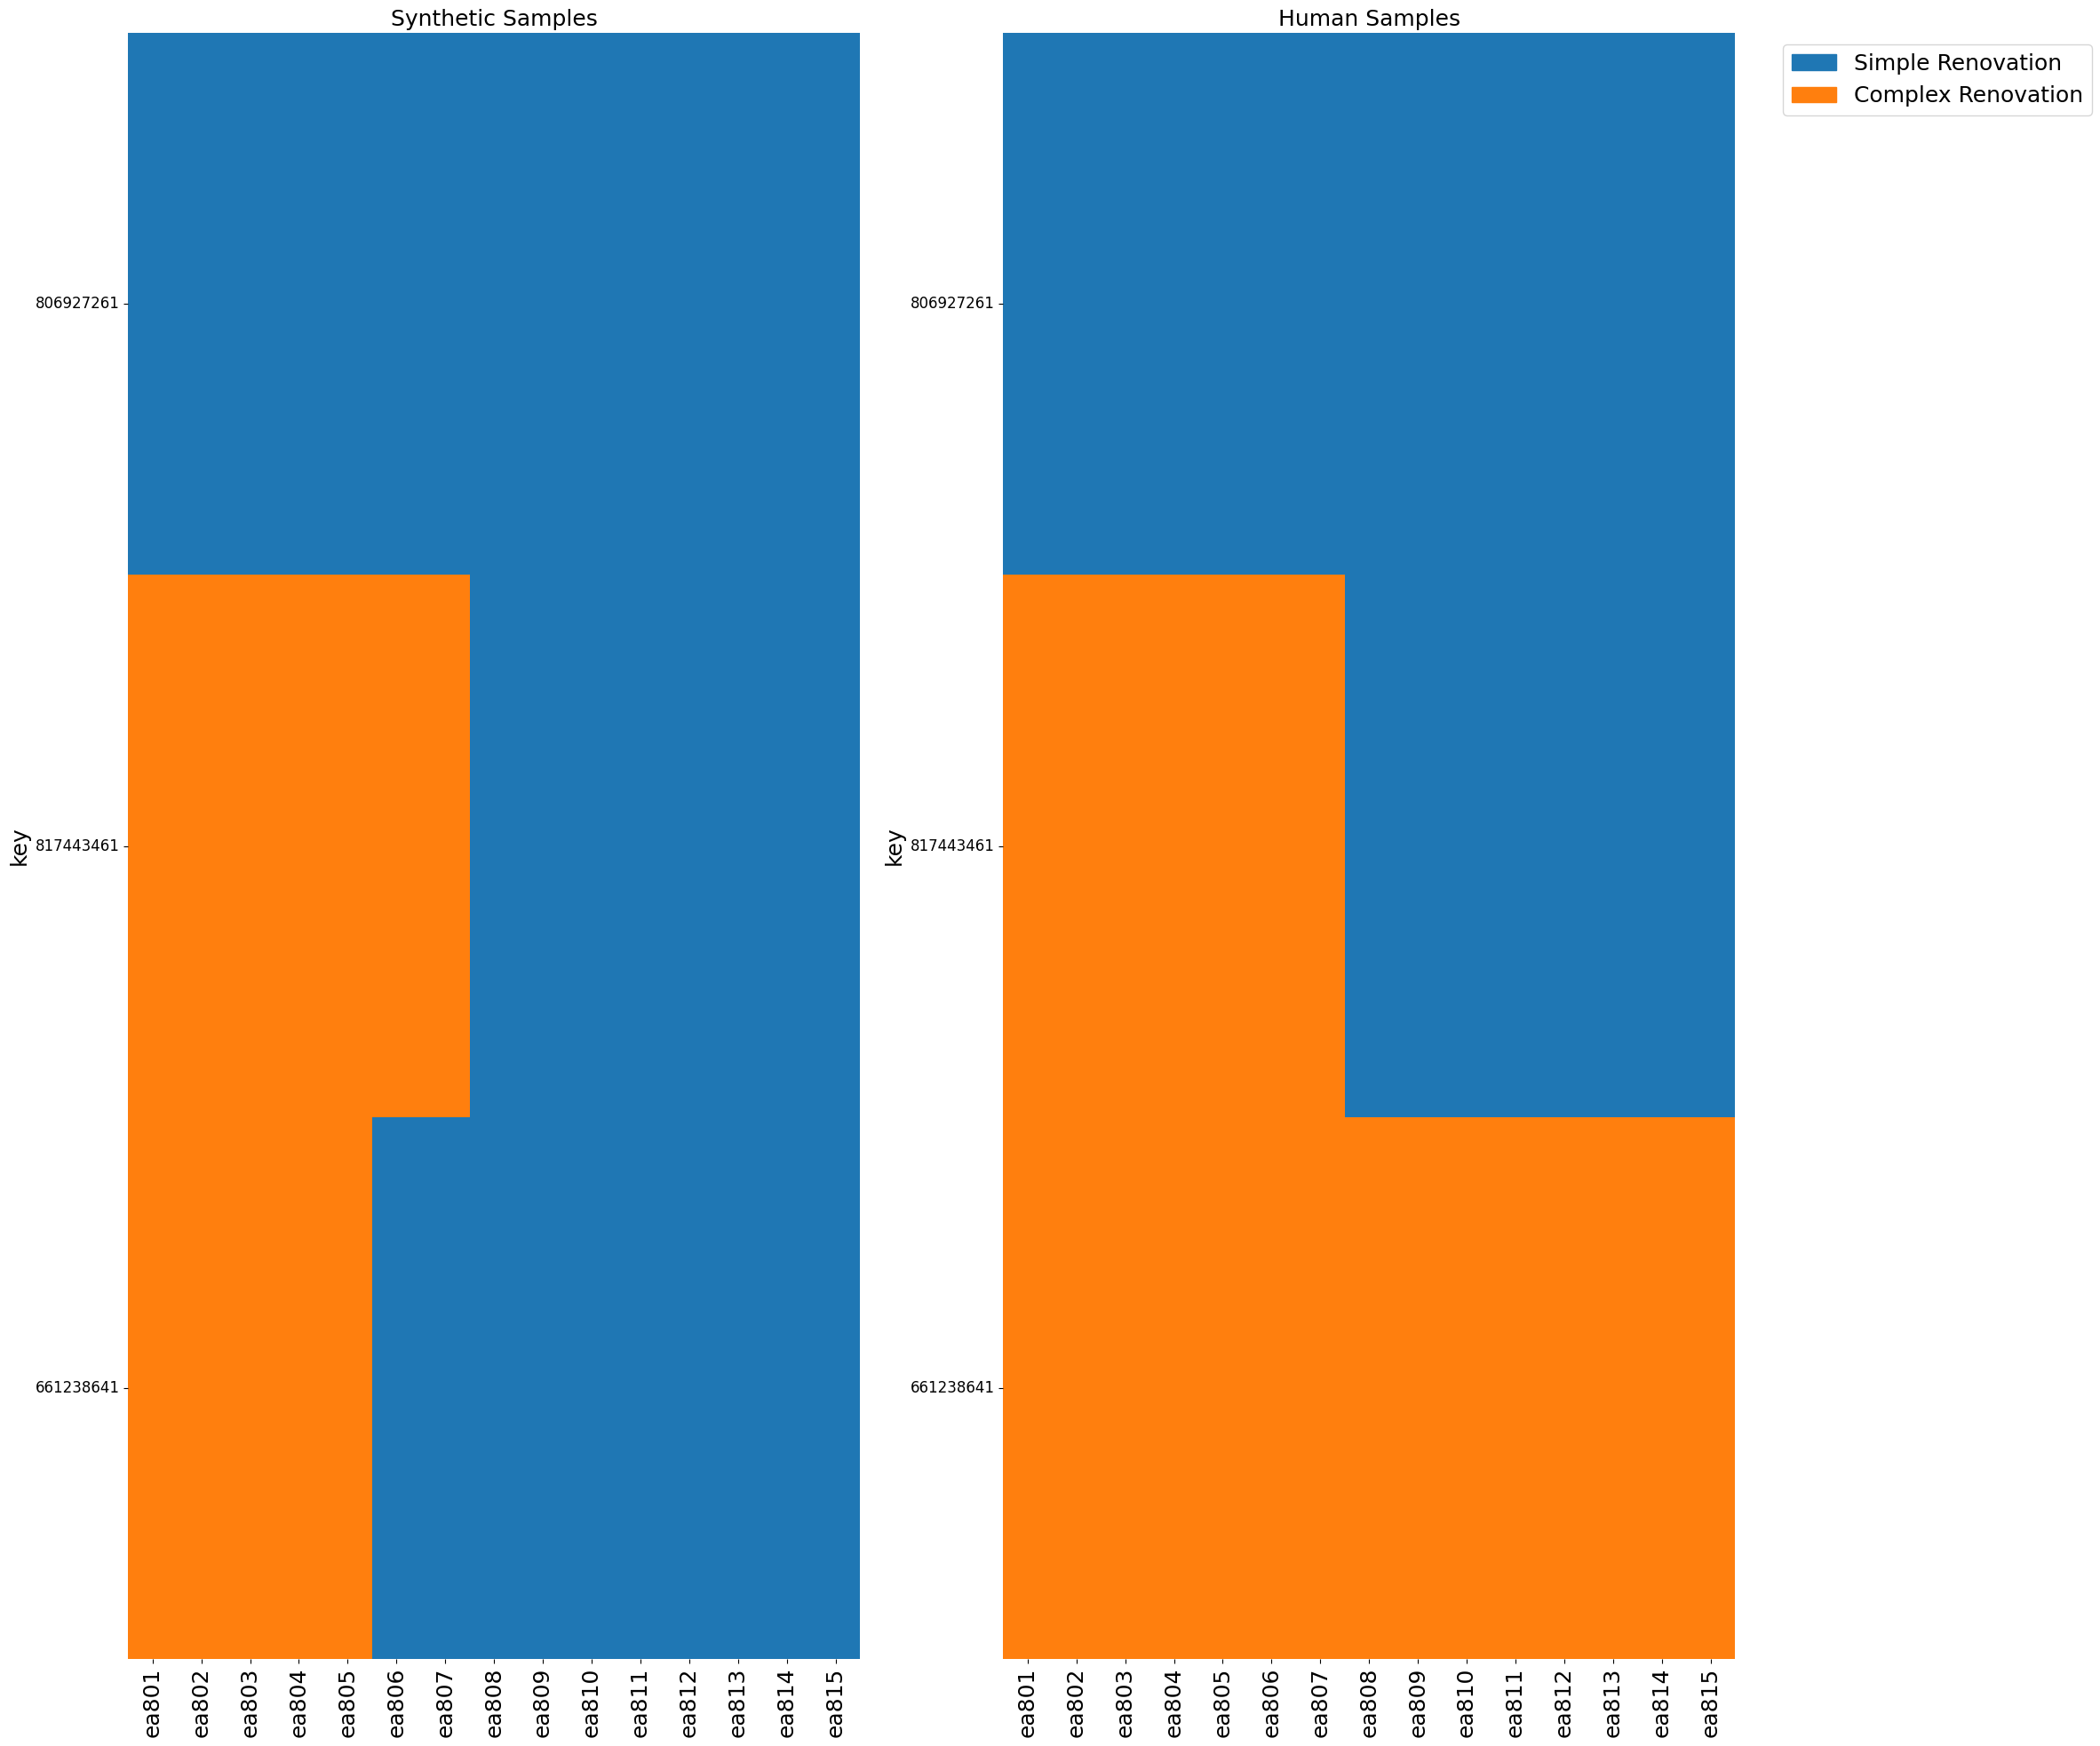

In [15]:
df_human_sample = df_sample[(df_sample['citizen_type']!='defier') & (df_sample['key'].isin([806927261, 661238641, 817443461]))].head(10)[['key']+final_columns]
output_file = '../../../data/ariadne/heating_buildings/experiment_1/20240102_1512/recurrent_gpt-4-1106-preview-t_0.6_qa.csv'
df_synthetic_samples = pd.read_csv(output_file)
df_synthetic_samples = df_synthetic_samples[(df_synthetic_samples['iter']==1)&(df_synthetic_samples['temperature']==0.6)]
exp_run.compare_results(df_human_sample, df_synthetic_samples)

#### 3.3.1. Results temperature 0.6 iteration 3

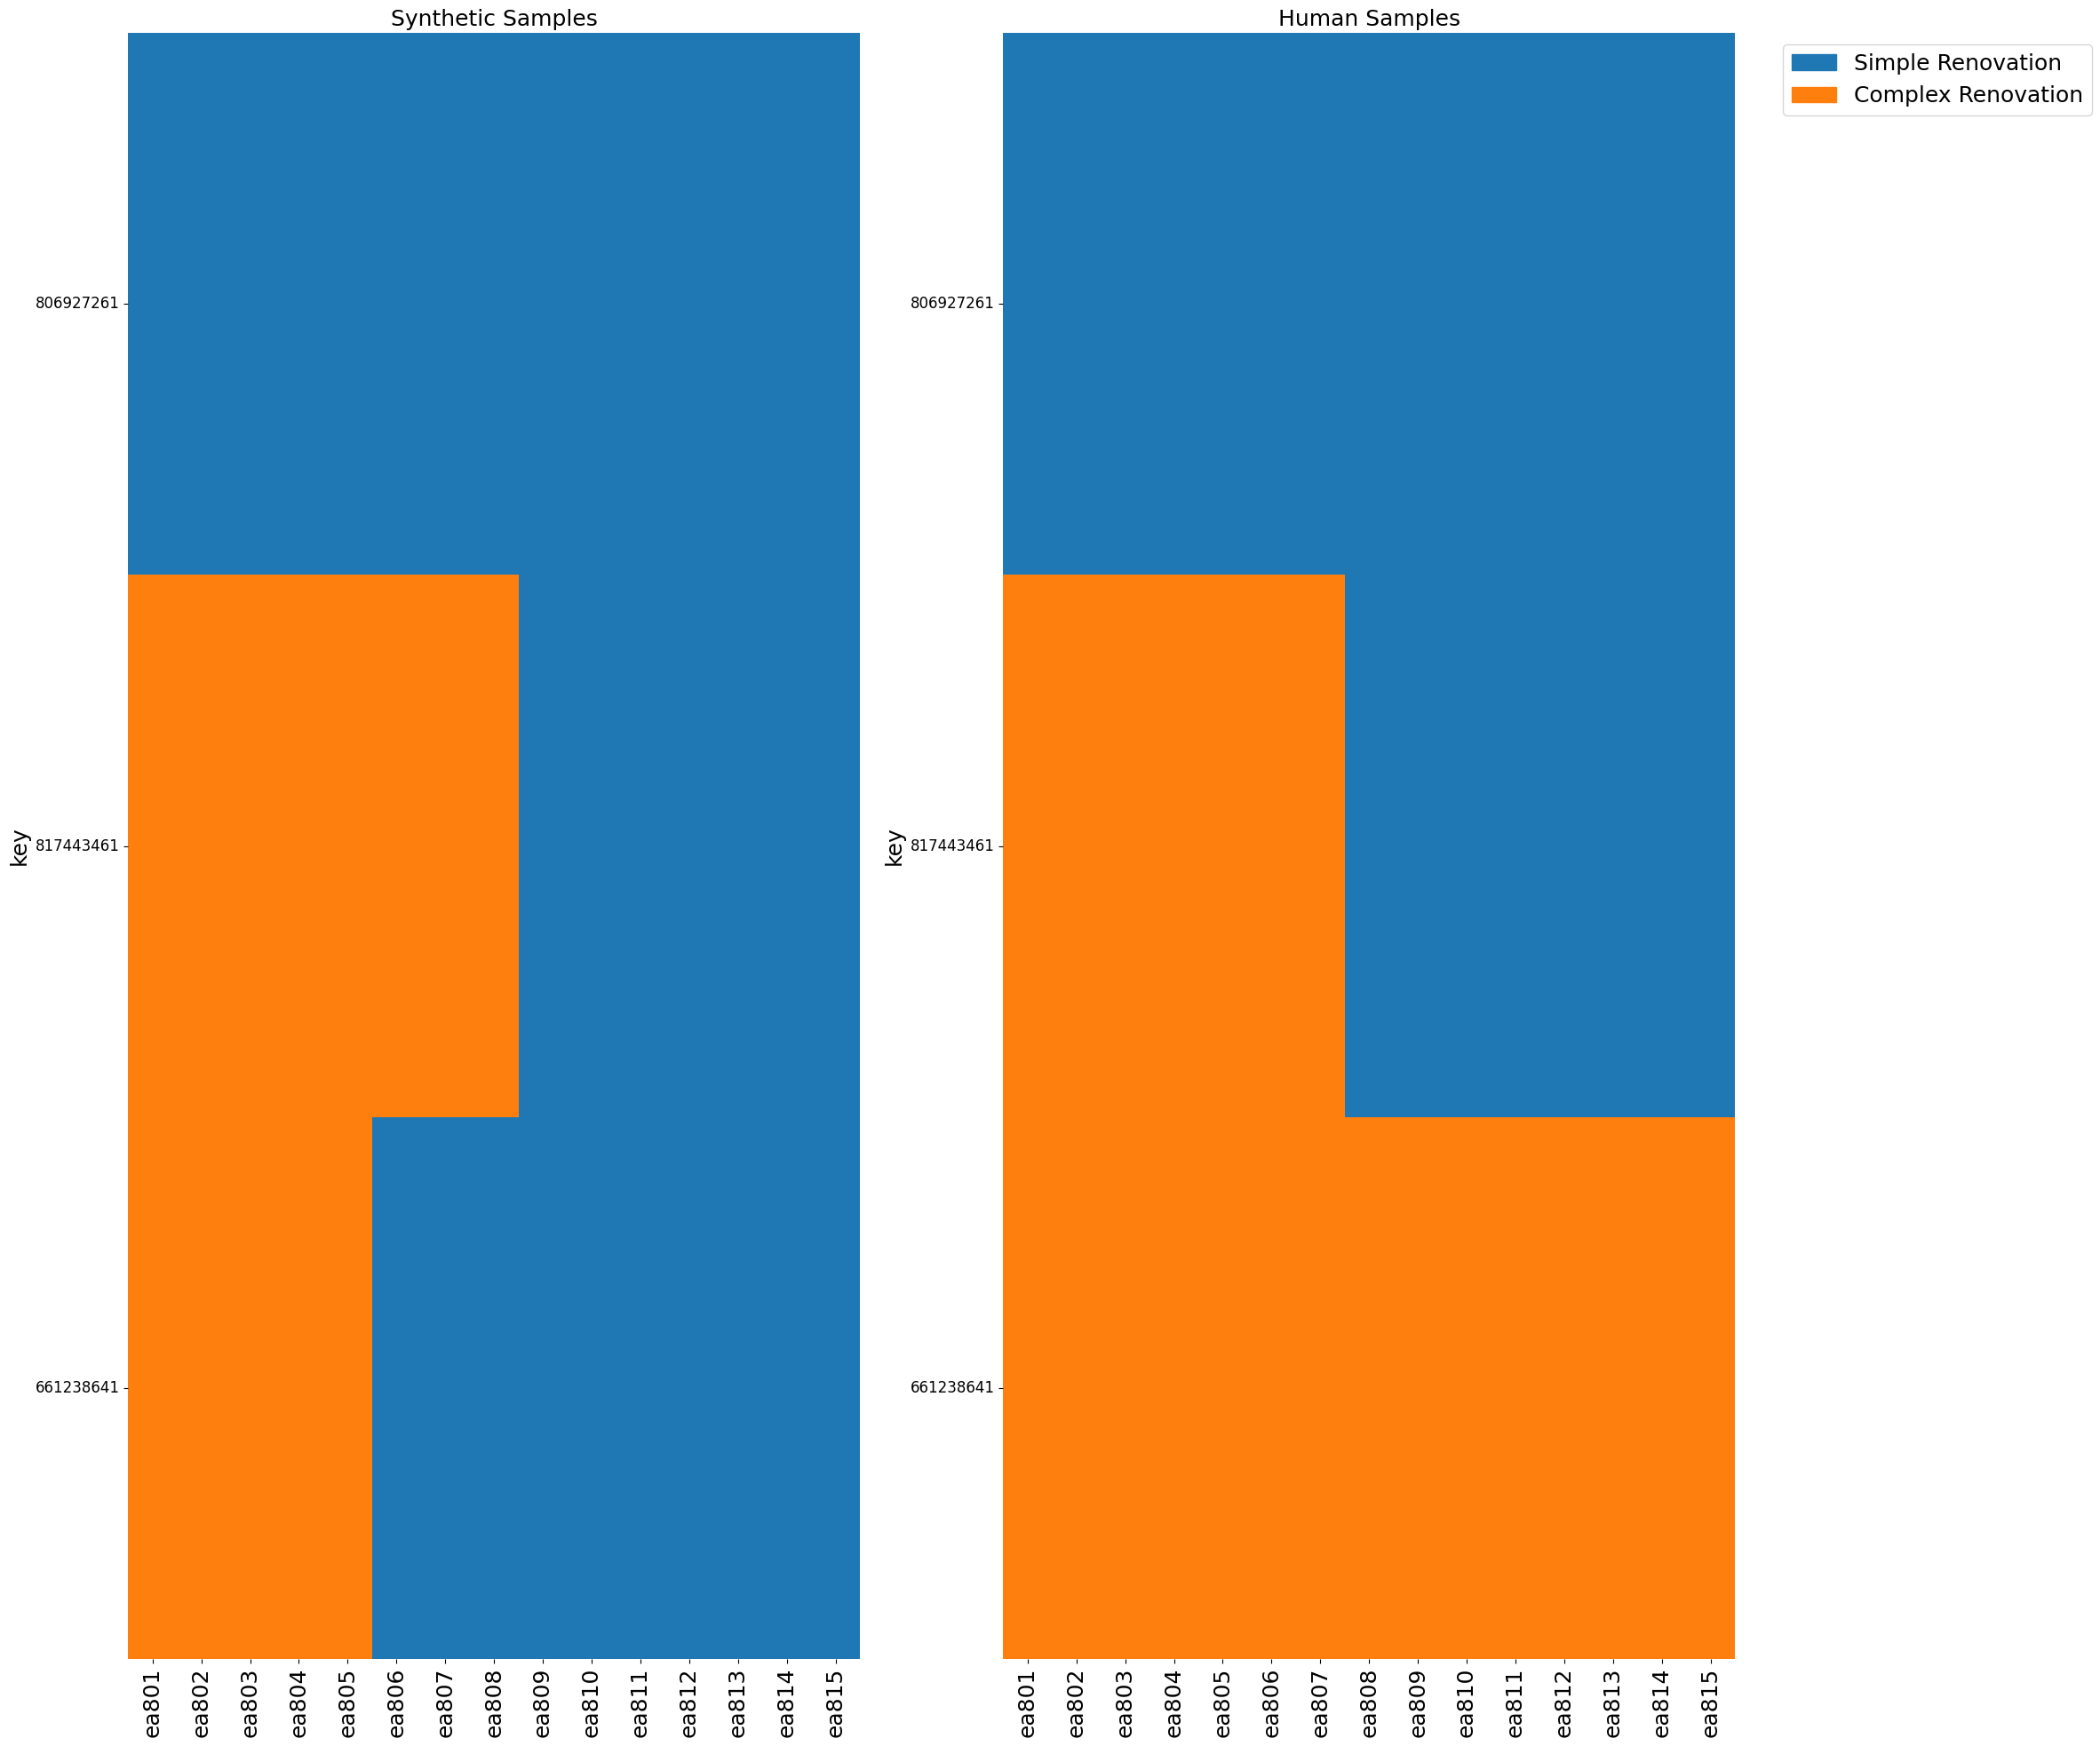

In [16]:
df_human_sample = df_sample[(df_sample['citizen_type']!='defier') & (df_sample['key'].isin([806927261, 661238641, 817443461]))].head(10)[['key']+final_columns]
output_file = '../../../data/ariadne/heating_buildings/experiment_1/20240102_1512/recurrent_gpt-4-1106-preview-t_0.6_qa.csv'
df_synthetic_samples = pd.read_csv(output_file)
df_synthetic_samples = df_synthetic_samples[(df_synthetic_samples['iter']==2)&(df_synthetic_samples['temperature']==0.6)]
exp_run.compare_results(df_human_sample, df_synthetic_samples)